# Old Code

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

ModuleNotFoundError: No module named 'sklearnex'

In [21]:
!git clone https://github.com/sunaabkukal/Winter-Rye-Modelling.git

Cloning into 'Winter-Rye-Modelling'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 457.67 KiB | 3.09 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and prep
df = pd.read_csv('../Data/final_data.csv')
features = [
    'rye_biomass', 'year', 'fall_N_rate', 'spring_N_rate', 'row_id',
    'num_days_fall', 'num_days_spring', 'num_cold_days_fall', 'num_cold_days_spring',
    'num_cold_days_winter', 'total_cold_days', 'frequency_cold_days',
    'RHavg_avg_fall', 'RHavg_avg_spring', 'RHavg_avg_winter', 'VPD_avg_fall',
    'VPD_avg_spring', 'VPD_avg_winter', 'PAR_sum_fall', 'PAR_sum_spring',
    'PAR_sum_winter', 'GDD_sum_fall', 'GDD_sum_spring', 'GDD_sum_winter',
    'FDD_sum_fall', 'FDD_sum_spring', 'FDD_sum_winter', 'rain_plant',
    'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter', 'ET0_sum_fall',
    'ET0_sum_spring', 'ET0_sum_winter'
]

# Include site_name initially for splitting logic
df_model = df[features + ['site_name']].copy()

# Data Cleaning
for col in features:
    if col != 'year':
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')
df_model = df_model.dropna()

In [ ]:

# Load the dataset
df = pd.read_csv('../Data/final_data.csv')

# Define the columns to keep
features = [
    'rye_biomass', 'year', 'fall_N_rate', 'spring_N_rate', 'row_id',
    'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter',
    'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter'
]

# Create the subset
df_model = df[features].copy()
print(df_model.head())
print(f"\nSubset Shape: {df_model.shape}")

# --- DATA CLEANING ---
# Coerce all columns to numeric. Errors (like '#NUM!') become NaN
for col in features:
    if col != 'year': # Keep year as string/object if it is one, though it usually is int
         df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop rows with any NaN values resulting from coercion
df_model = df_model.dropna()
print(f"Data shape after cleaning: {df_model.shape}")

   rye_biomass       year  fall_N_rate  spring_N_rate  row_id  rain_plant  \
0  4013.333333  2005-2006          0.0            0.0       1        11.3   
1  2570.000000  2005-2006          0.0            0.0       2        11.3   
2  3626.666667  2005-2006          0.0            0.0       3        11.3   
3  4106.666667  2005-2006          0.0            0.0       4        11.3   
4  3803.333333  2005-2006          0.0            0.0       5        11.3   

   rain_sum_fall  rain_sum_spring  rain_sum_winter  ET0_sum_fall  \
0           51.7            121.9             50.6         162.0   
1           51.7            121.9             50.6         162.0   
2           51.7            121.9             50.6         162.0   
3           51.7            121.9             50.6         162.0   
4           51.7            121.9             50.6         162.0   

   ET0_sum_spring  ET0_sum_winter  
0           239.5           119.2  
1           239.5           119.2  
2           239.5   

In [ ]:
# --- SPLIT LOGIC ---
# 1. Identify multi-year sites and their last year
site_stats = df_model.groupby('site_name')['year'].agg(['nunique', 'max'])
multi_year_sites = site_stats[site_stats['nunique'] > 1]['max'].to_dict()

# 2. Create Validation Mask
# Row is validation if site is in multi_year_sites AND year matches its max year
def is_val(row):
    return row['site_name'] in multi_year_sites and row['year'] == multi_year_sites[row['site_name']]

val_mask = df_model.apply(is_val, axis=1)

# 3. Create Sets
val_data = df_model[val_mask].drop(columns=['site_name'])
temp_data = df_model[~val_mask].drop(columns=['site_name'])

train_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

# Verify
print(f"Validation: {val_data.shape}")
print(f"Train: {train_data.shape}, Test: {test_data.shape}")

Validation: (243, 34)
Train: (664, 34), Test: (166, 34)


In [ ]:
features_X = [c for c in df_model.columns if c not in ['rye_biomass', 'year', 'row_id']]
X = df_model[features_X]
y = df_model['rye_biomass']
groups = df_model['year']

# Lists to store ALL predictions and true values
all_y_true = []
all_y_pred = []

# Metric lists for reference (optional, can skip years with <2 samples)
rmse_scores = []

logo = LeaveOneGroupOut()

print(f"Starting Leave-One-Year-Out CV on {len(np.unique(groups))} years...")

for train_idx, test_idx in logo.split(X, y, groups=groups):
    # 1. Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 2. Process
    y_train_log = np.log1p(y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Train
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_train_scaled, y_train_log)

    # 4. Predict
    y_pred_log = rf.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)

    # 5. Store Global Results
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # 6. Per-Year Metrics (Calculate RMSE only, it works for single points)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    test_year = groups.iloc[test_idx].unique()[0]
    print(f"Year: {test_year} | Samples: {len(y_test)} | RMSE: {rmse:.1f}")

# --- FINAL CALCULATION ---
global_r2 = r2_score(all_y_true, all_y_pred)
global_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))

print("\n--- LOYO Performance ---")
print(f"Global R2:   {global_r2:.4f}")
print(f"Global RMSE: {global_rmse:.4f}")

Starting Leave-One-Year-Out CV on 23 years...


ValueError: could not convert string to float: 'Agricultural Engineering and Agronomy Research Farm (AEARF)'

<bound method ForestRegressor.fit of RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)>

In [ ]:
# --- STRATEGY 1: LOG TRANSFORM TARGET ---
# Reduces impact of outliers and normalizes distribution
y_train_log = np.log1p(y_train)

# --- STRATEGY 2: EXTRACT GROUPS FOR CV ---
# We need 'year' to group folds, preventing data leakage during tuning
groups_train = train_data['year']

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

NameError: name 'y_train' is not defined

In [ ]:
# Define Group Splitter
gkf = GroupKFold(n_splits=5) # Splits based on 'year', not random rows

# 1. RFECV with GroupKFold
print(f"Running RFECV with GroupKFold...")
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=rf_base,
    step=1,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
# Pass groups=groups_train to ensure years are held out
rfecv.fit(X_train_scaled, y_train_log, groups=groups_train)

print(f"Optimal features: {rfecv.n_features_}")
selected_feat = [predictors[i] for i in range(len(predictors)) if rfecv.support_[i]]
print(f"Selected: {selected_feat}")

X_train_opt = rfecv.transform(X_train_scaled)
X_test_opt = rfecv.transform(X_test_scaled)
X_val_opt = rfecv.transform(X_val_scaled)


Running RFECV with GroupKFold...


NameError: name 'X_train_scaled' is not defined

In [ ]:
# 2. Grid Search with GroupKFold
print("\nStarting Hyperparameter Tuning with GroupKFold...")
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': list(range(3, 15, 2)),
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [4, 8, 12, 16, 20],
    'max_features': ['sqrt', 0.3, 0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=1),
    param_grid=param_grid,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_opt, y_train_log, groups=groups_train)
best_rf = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")



Starting Hyperparameter Tuning with GroupKFold...
Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
Best Params: {'max_depth': 5, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [ ]:
# Evaluate
# IMPORTANT: Inverse transform predictions (exp) to get back to biomass units
y_train_pred = np.expm1(best_rf.predict(X_train_opt))
y_test_pred = np.expm1(best_rf.predict(X_test_opt))
y_val_pred = np.expm1(best_rf.predict(X_val_opt))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\n--- Final Performance (Log-Transformed + GroupCV) ---")
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}, RMSE: {test_rmse:.4f}")
print(f"Val R2:  {r2_score(y_val, y_val_pred):.4f}, RMSE: {val_rmse:.4f}")


--- Final Performance (Log-Transformed + GroupCV) ---
Test R2: 0.7205, RMSE: 1653.6702
Val R2:  -0.1301, RMSE: 5123.5743


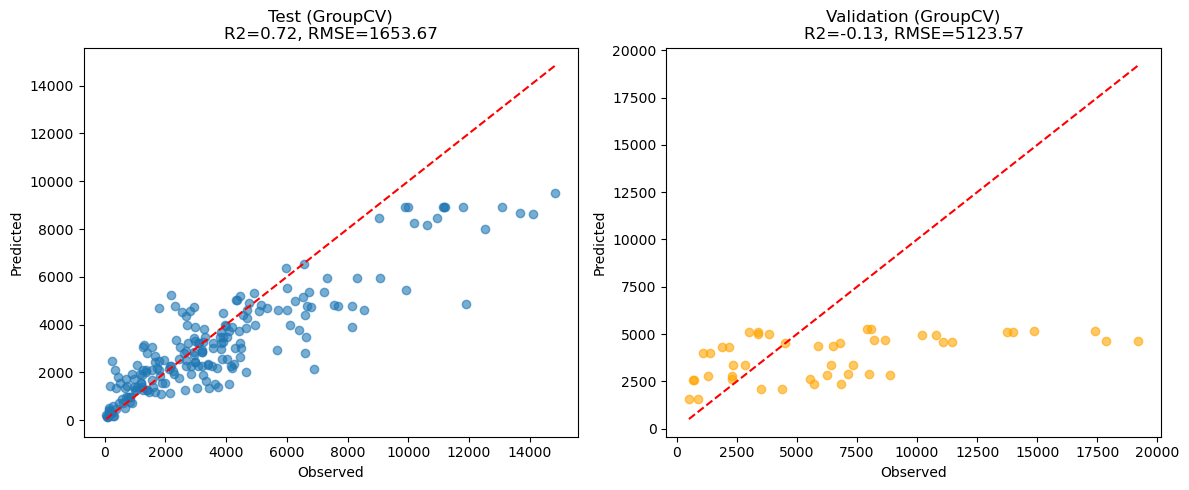

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_test, y_test_pred, alpha=0.6)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title(f'Test (GroupCV)\nR2={r2_score(y_test, y_test_pred):.2f}, RMSE={test_rmse:.2f}')
ax1.set_xlabel('Observed')
ax1.set_ylabel('Predicted')

ax2.scatter(y_val, y_val_pred, alpha=0.6, color='orange')
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_title(f'Validation (GroupCV)\nR2={r2_score(y_val, y_val_pred):.2f}, RMSE={val_rmse:.2f}')
ax2.set_xlabel('Observed')
ax2.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# Task
Provide a comprehensive summary of the `df_model` DataFrame, including its first few rows, shape, data types, descriptive statistics for numerical columns, a report on any missing values, and visualizations of key feature distributions (histograms for numerical features, and a bar chart for 'year').

## Initial Data Overview

### Subtask:
Display the first few rows of the `df_model` DataFrame, along with its shape and data types, to get a preliminary understanding of the data structure.


**Reasoning**:
To understand the structure, content, and data types of the `df_model` DataFrame, I will display its first few rows, its shape, and a summary of its columns and their data types.



In [4]:
print("First 5 rows of df_model:")
print(df_model.head())

print(f"\nShape of df_model: {df_model.shape}")

print("\nData types and non-null counts of df_model:")
df_model.info()

First 5 rows of df_model:


NameError: name 'df_model' is not defined

**Reasoning**:
The previous attempt to display `df_model` information failed because `df_model` was not defined in the current kernel session. To resolve this, I will re-execute the code that defines and cleans `df_model` (from cell `45262a7f`), and then immediately display its first few rows, shape, and data types, as requested by the subtask.



In [5]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Coding Data/final_data.csv')

# Define the columns to keep
features = [
    'rye_biomass', 'year', 'fall_N_rate', 'spring_N_rate', 'row_id',
    'rain_plant', 'rain_sum_fall', 'rain_sum_spring', 'rain_sum_winter',
    'ET0_sum_fall', 'ET0_sum_spring', 'ET0_sum_winter'
]

# Create the subset
df_model = df[features].copy()

# --- DATA CLEANING ---
# Coerce all columns to numeric. Errors (like '#NUM!') become NaN
for col in features:
    if col != 'year': # Keep year as string/object if it is one, though it usually is int
         df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop rows with any NaN values resulting from coercion
df_model = df_model.dropna()

# Display the first few rows, shape, and data types of df_model
print("First 5 rows of df_model:")
print(df_model.head())

print(f"\nShape of df_model: {df_model.shape}")

print("\nData types and non-null counts of df_model:")
df_model.info()

First 5 rows of df_model:
   rye_biomass       year  fall_N_rate  spring_N_rate  row_id  rain_plant  \
0  4013.333333  2005-2006          0.0            0.0       1        11.3   
1  2570.000000  2005-2006          0.0            0.0       2        11.3   
2  3626.666667  2005-2006          0.0            0.0       3        11.3   
3  4106.666667  2005-2006          0.0            0.0       4        11.3   
4  3803.333333  2005-2006          0.0            0.0       5        11.3   

   rain_sum_fall  rain_sum_spring  rain_sum_winter  ET0_sum_fall  \
0           51.7            121.9             50.6         162.0   
1           51.7            121.9             50.6         162.0   
2           51.7            121.9             50.6         162.0   
3           51.7            121.9             50.6         162.0   
4           51.7            121.9             50.6         162.0   

   ET0_sum_spring  ET0_sum_winter  
0           239.5           119.2  
1           239.5           11

## Descriptive Statistics

### Subtask:
Generate descriptive statistics for all numerical columns in `df_model` to understand their central tendency, dispersion, and shape of distribution.


**Reasoning**:
To understand the central tendency, dispersion, and shape of distribution for numerical features, I will use the `.describe()` method on the `df_model` DataFrame to generate descriptive statistics for all numerical columns.



In [6]:
print("Descriptive statistics for numerical columns in df_model:")
print(df_model.describe())

Descriptive statistics for numerical columns in df_model:
        rye_biomass  fall_N_rate  spring_N_rate      row_id   rain_plant  \
count   1111.000000  1111.000000    1111.000000  1111.00000  1111.000000   
mean    3766.185191    18.784140      14.053708   556.00000    88.322502   
std     3160.801502    41.693342      29.572537   320.86238    60.917627   
min       17.166667     0.000000       0.000000     1.00000     4.200000   
25%     1319.547500     0.000000       0.000000   278.50000    43.100000   
50%     2964.145000     0.000000       0.000000   556.00000    83.600000   
75%     5099.430000     0.000000       0.000000   833.50000   114.100000   
max    19203.520000   201.780000     223.220000  1111.00000   337.400000   

       rain_sum_fall  rain_sum_spring  rain_sum_winter  ET0_sum_fall  \
count    1111.000000      1111.000000      1111.000000   1111.000000   
mean      132.559046       157.206391       218.683348    151.813951   
std        87.533607        96.547272    

## Check for Missing Values

### Subtask:
Identify and report any remaining missing values in the `df_model` DataFrame to confirm data completeness after the cleaning steps.


**Reasoning**:
To identify any remaining missing values in the `df_model` DataFrame after the cleaning steps, I will calculate the sum of null values for each column.



In [7]:
print("Missing values in df_model after cleaning:")
print(df_model.isnull().sum())

Missing values in df_model after cleaning:
rye_biomass        0
year               0
fall_N_rate        0
spring_N_rate      0
row_id             0
rain_plant         0
rain_sum_fall      0
rain_sum_spring    0
rain_sum_winter    0
ET0_sum_fall       0
ET0_sum_spring     0
ET0_sum_winter     0
dtype: int64


## Visualize Key Distributions

### Subtask:
Create visualizations, such as histograms for key numerical features and a bar chart for 'year' to show the distribution of observations across different years, to get a visual sense of the data.


## Visualize Key Distributions

### Subtask:
Create visualizations, such as histograms for key numerical features and a bar chart for 'year' to show the distribution of observations across different years, to get a visual sense of the data.


**Reasoning**:
To visualize the distribution of numerical features and the frequency of observations across years, I will generate histograms for the identified numerical columns and a bar chart for the 'year' column, as requested by the subtask.



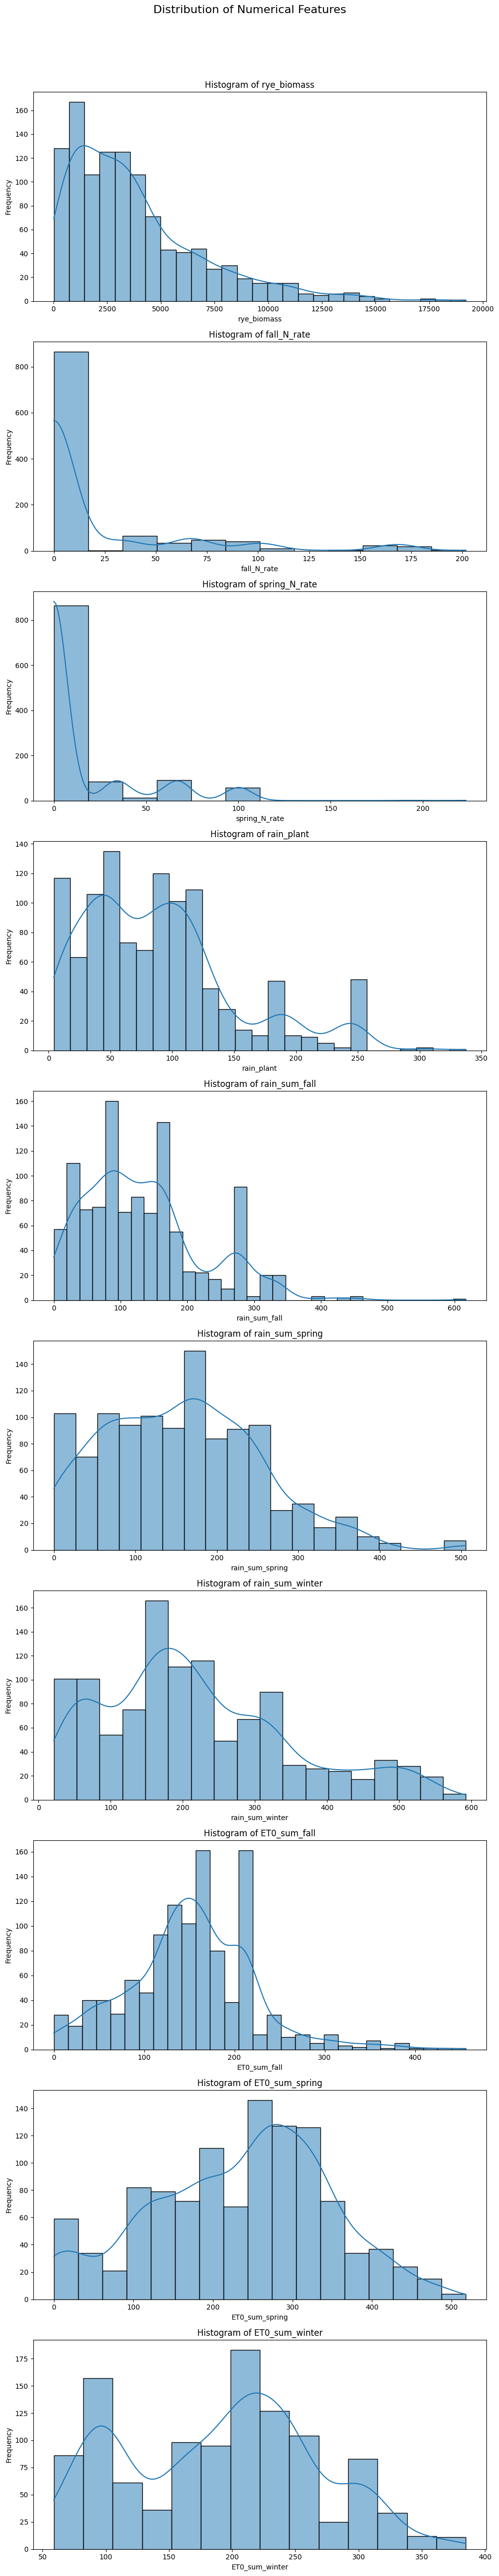

/tmp/ipython-input-3775060489.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_model, x='year', palette='viridis')


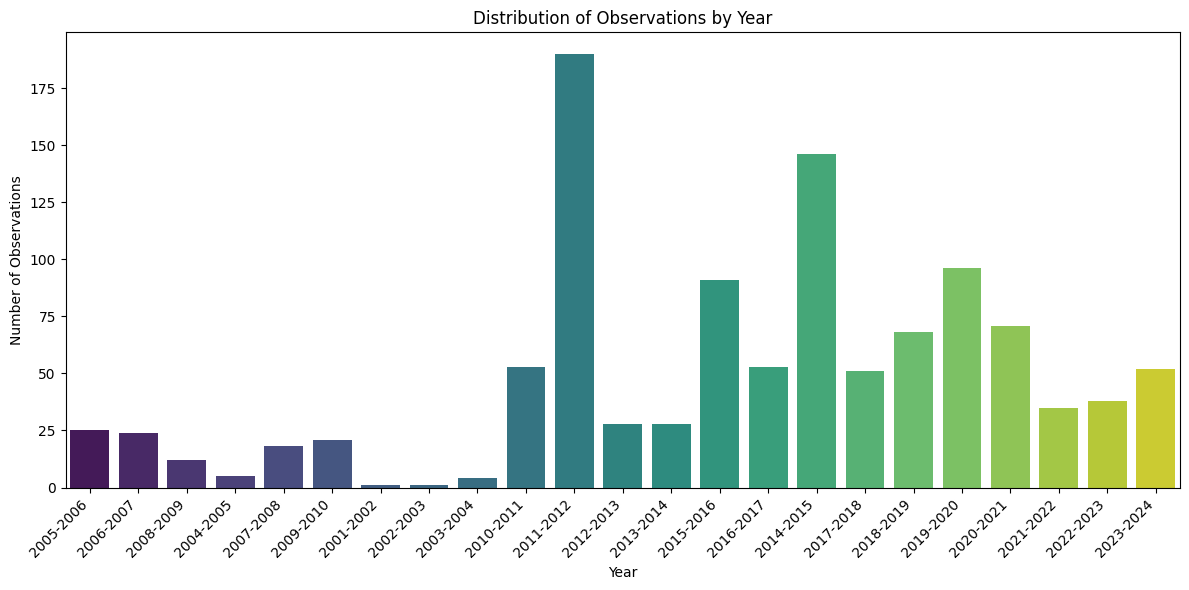

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns for histograms, excluding 'row_id' and 'year'
numerical_cols = df_model.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_cols = ['row_id', 'year']
num_cols_for_hist = [col for col in numerical_cols if col not in exclude_cols]

# Create histograms for numerical features
fig, axes = plt.subplots(nrows=len(num_cols_for_hist), ncols=1, figsize=(10, 5 * len(num_cols_for_hist)))
fig.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(num_cols_for_hist):
    sns.histplot(df_model[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create a bar chart for 'year' distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_model, x='year', palette='viridis')
plt.title('Distribution of Observations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
To address the `FutureWarning` from seaborn regarding the `palette` argument without `hue`, I will update the `sns.countplot` call to explicitly set `hue='year'` and `legend=False` as suggested by the warning. This will make the code compatible with future seaborn versions while maintaining the desired visualization.



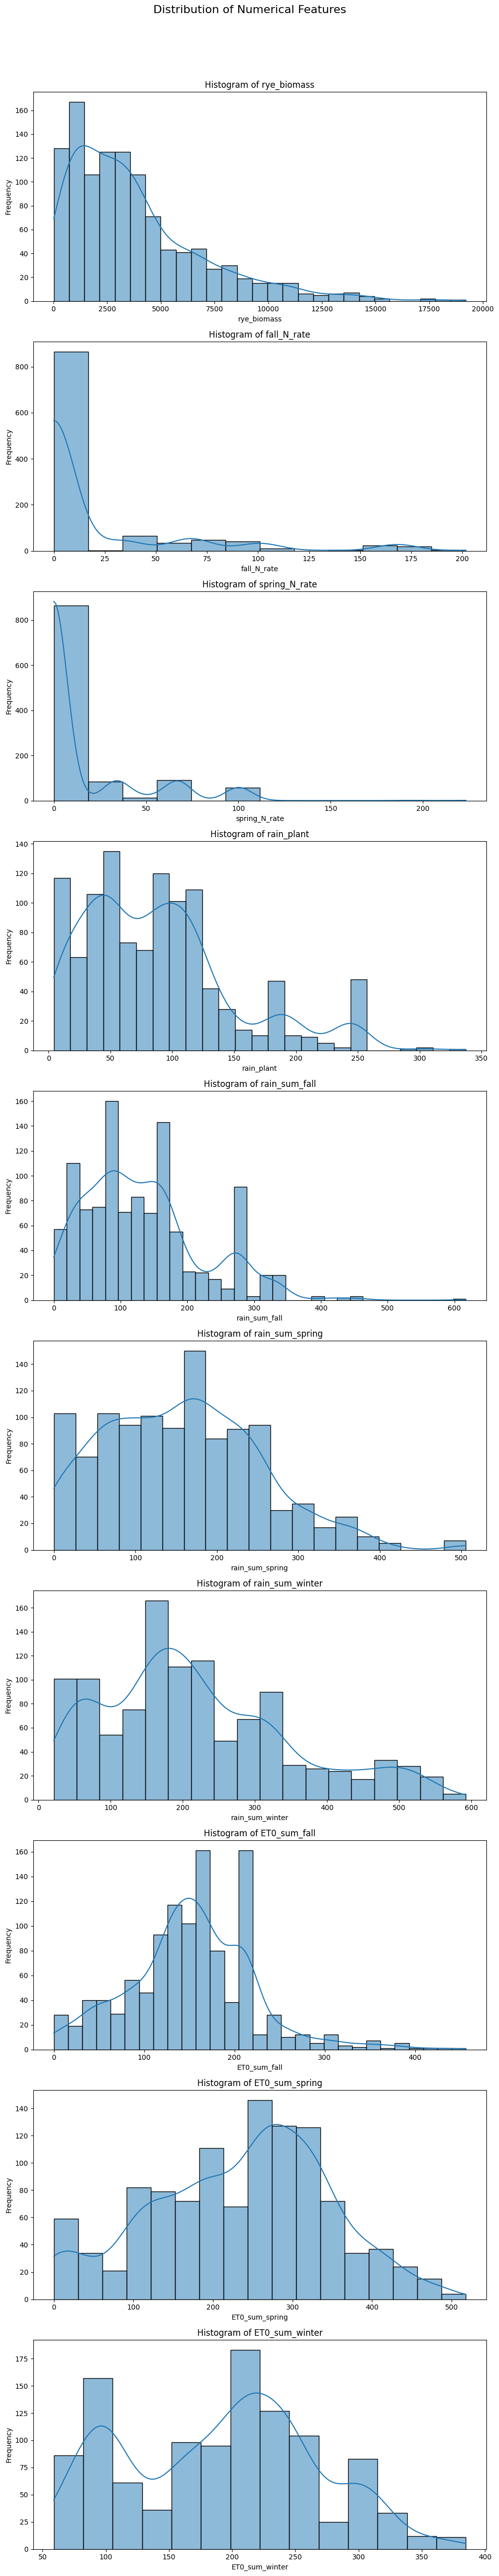

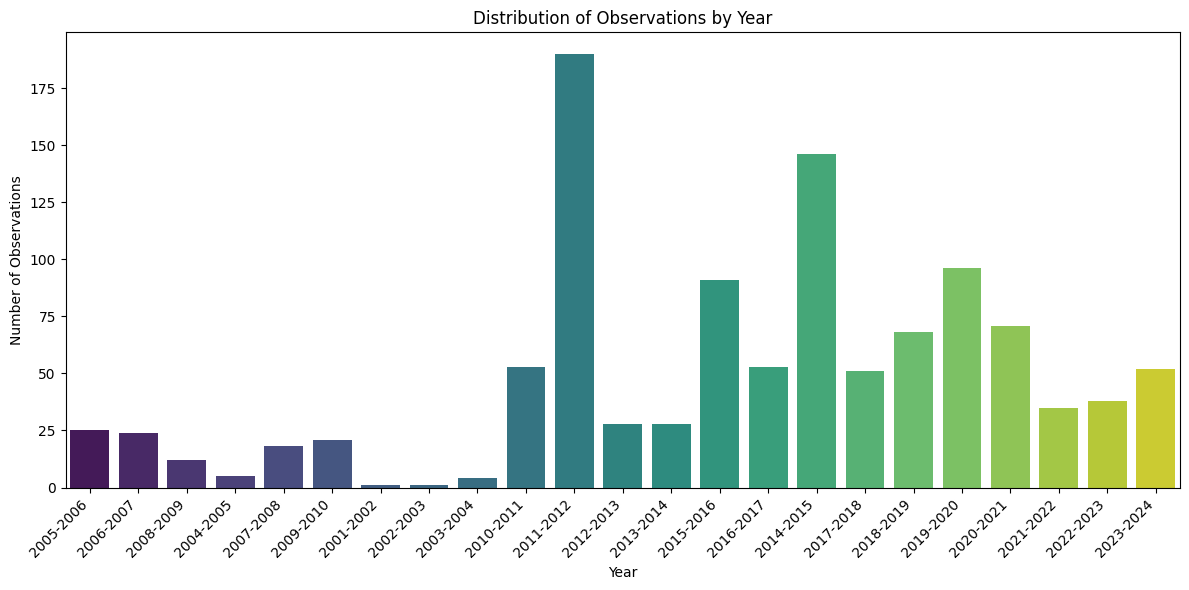

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns for histograms, excluding 'row_id' and 'year'
numerical_cols = df_model.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_cols = ['row_id', 'year']
num_cols_for_hist = [col for col in numerical_cols if col not in exclude_cols]

# Create histograms for numerical features
fig, axes = plt.subplots(nrows=len(num_cols_for_hist), ncols=1, figsize=(10, 5 * len(num_cols_for_hist)))
fig.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(num_cols_for_hist):
    sns.histplot(df_model[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create a bar chart for 'year' distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df_model, x='year', hue='year', palette='viridis', legend=False)
plt.title('Distribution of Observations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Provide a comprehensive summary of the dataset, highlighting key characteristics, distributions, and any significant patterns observed from the overview and visualizations.


## Summary:

### Data Analysis Key Findings
*   The `df_model` DataFrame contains 1111 rows and 12 columns.
*   Initial data cleaning involved coercing specified feature columns to numeric types and dropping rows with any resulting missing values, ensuring a complete dataset with zero missing values across all columns.
*   The `year` column is of `object` type (e.g., '2005-2006'), `row_id` is `int64`, and all other 10 feature columns (`rye_biomass`, `fall_N_rate`, `spring_N_rate`, `rain_plant`, `rain_sum_fall`, `rain_sum_spring`, `rain_sum_winter`, `ET0_sum_fall`, `ET0_sum_spring`, `ET0_sum_winter`) are `float64`.
*   Descriptive statistics for numerical columns indicate a wide range for `rye_biomass` (from 17.17 to 19203.52) with a mean of 3766.19 and a standard deviation of 3160.80, suggesting a potentially right-skewed distribution. Other numerical features also show varying central tendencies and dispersions.
*   Visualizations using histograms confirmed the distributions of numerical features, with `rye_biomass` exhibiting a right-skewed pattern. A bar chart displayed the distribution of observations across different `year` periods.

### Insights or Next Steps
*   Given the significant skewness observed in key numerical features like `rye_biomass`, consider applying data transformations (e.g., log, square root) to normalize their distributions, which can be beneficial for certain statistical modeling techniques.
*   The `year` column, currently an `object` type representing a range, could be further processed. Converting it into a numerical representation (e.g., start year or average year) or a proper categorical type could facilitate time-series analysis or improve its utility in predictive models.
